<a href="https://colab.research.google.com/github/Sherlock-221BBS/vision_transformer/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 35.22 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224
BATCH_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
   batch_size = BATCH_SIZE
)

(-0.5, 223.5, 223.5, -0.5)

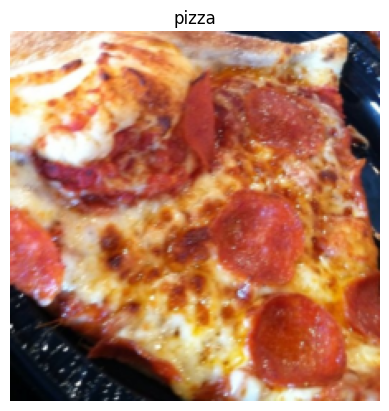

In [9]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[10], label_batch[10]

import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')


In [10]:
image.shape

torch.Size([3, 224, 224])

## 1. Split the image into patches and create class, patch, position embedding

In [11]:
image_height = 224
image_width = 224
color_channels = 3


patch_size = 16
number_of_patches = int((image_height * image_width)/patch_size ** 2)
embedding_layer_input_shape = (image_height, image_width)
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)

print(f"Embedding Layer input shape: {embedding_layer_input_shape}")
print(f"Embedding Layer output shape: {embedding_layer_output_shape}")

Embedding Layer input shape: (224, 224)
Embedding Layer output shape: (196, 768)


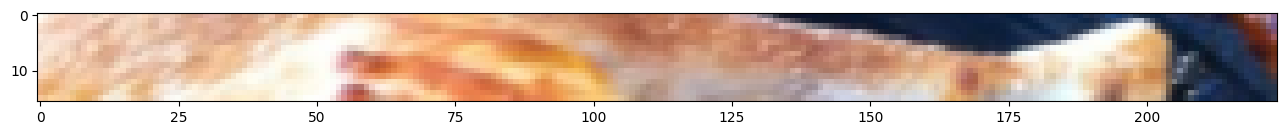

In [12]:
image_permuted = image.permute(1, 2, 0)
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Patch Size: 16 pixels x 16 pixels



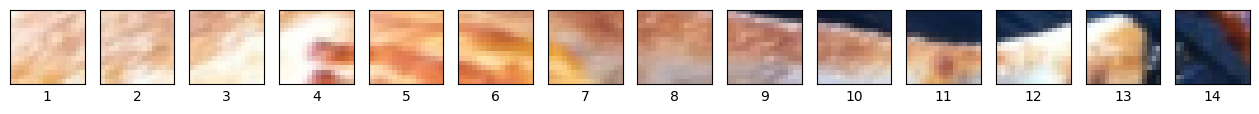

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image patch size must be divisible by patch size"
print(f"Patch Size: {patch_size} pixels x {patch_size} pixels\n")
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size//patch_size,
                        figsize = (patch_size, patch_size),
                        sharex = True,
                        sharey = True)

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch: patch + patch_size, :])
  axs[i].set_xlabel(i + 1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])



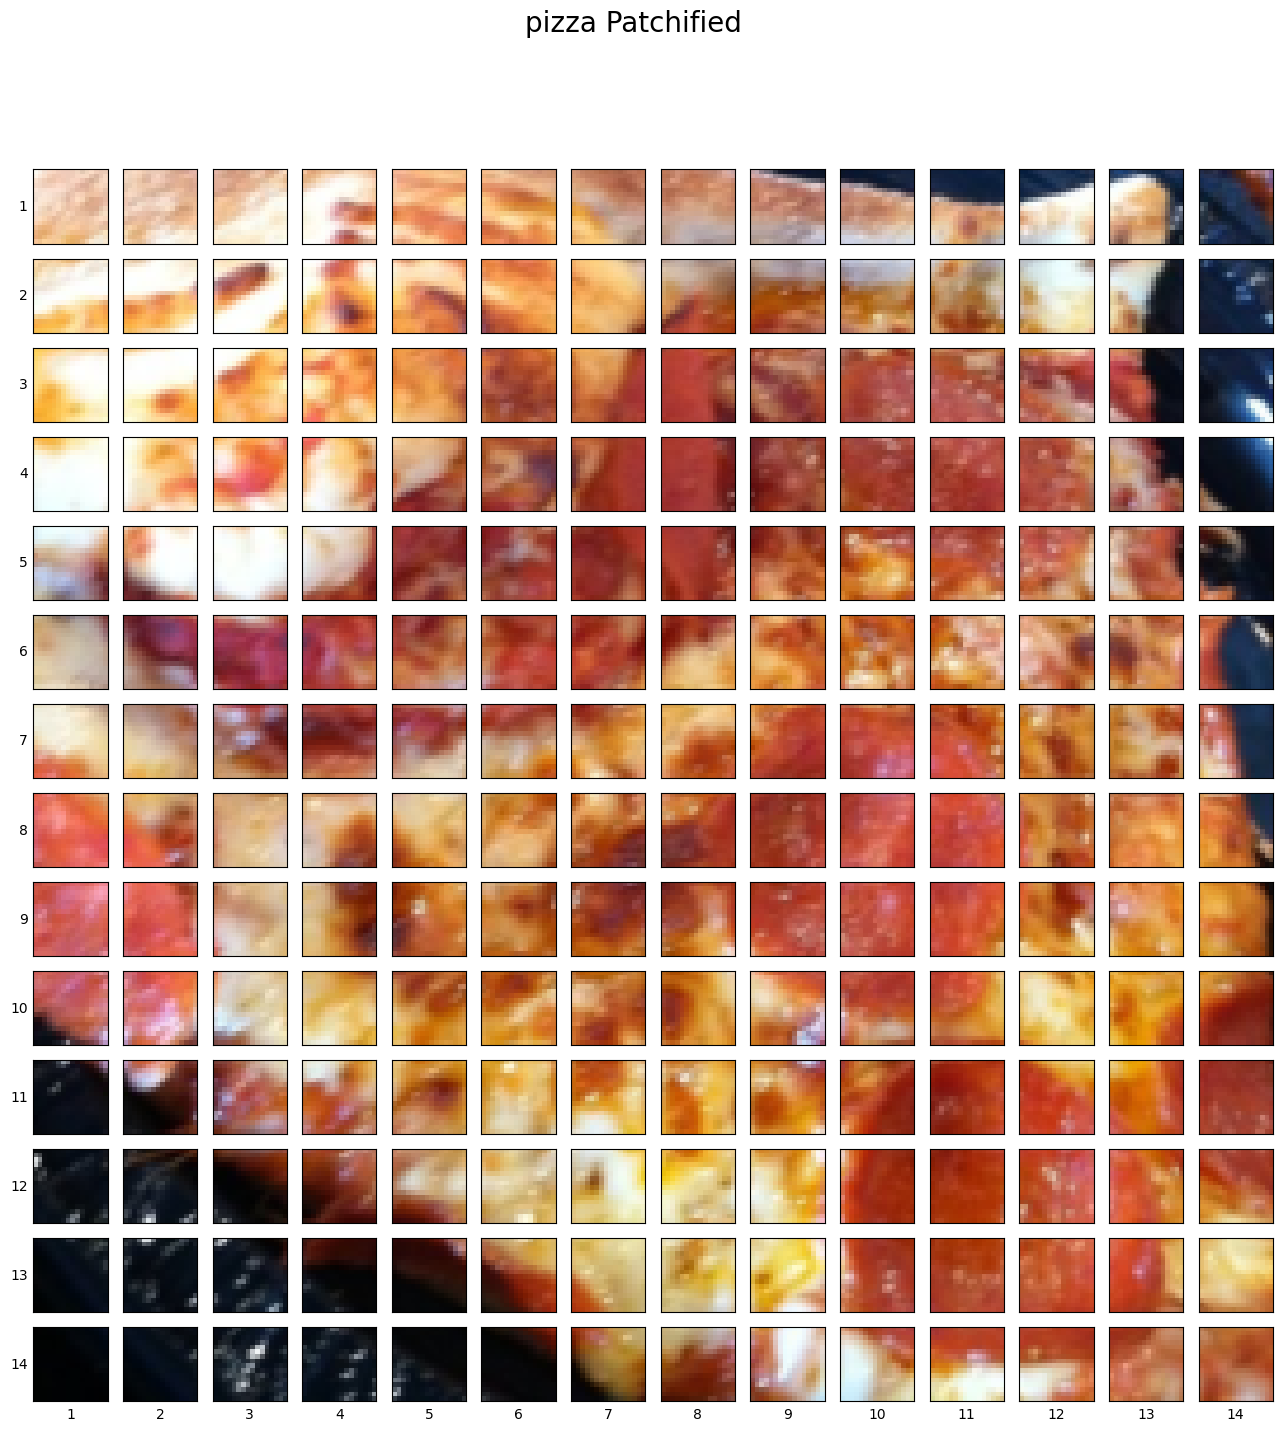

In [20]:
image_permuted = image.permute(1, 2, 0)
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch size"

fig, axs = plt.subplots(nrows = image_height // patch_size,
                        ncols = image_width // patch_size,
                        sharex = True,
                        sharey = True,
                        figsize = (patch_size, patch_size))

for i, patch_row in enumerate(range(0, image_height, patch_size)):
  for j, patch_col in enumerate(range(0, image_width, patch_size)):
    axs[i][j].imshow(image_permuted[patch_row: patch_row + patch_size, patch_col: patch_col + patch_size, : ])
    axs[i, j].set_ylabel(i + 1,
                         rotation = 'horizontal',
                         horizontalalignment = 'right',
                         verticalalignment = 'center')
    axs[i, j].set_xlabel(j + 1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} Patchified", fontsize = 20)
plt.show()

# Create Patch Embedding Layer using Conv2d

In [24]:
from torch import nn
patch_size = 16
image_channels = 3

conv2d = nn.Conv2d(in_channels = image_channels,
                   out_channels = patch_size * patch_size * image_channels,
                   stride = patch_size,
                   kernel_size = patch_size,
                   padding = 0)

image_out_of_conv2d = conv2d(image.unsqueeze(0))
image_out_of_conv2d.shape


torch.Size([1, 768, 14, 14])

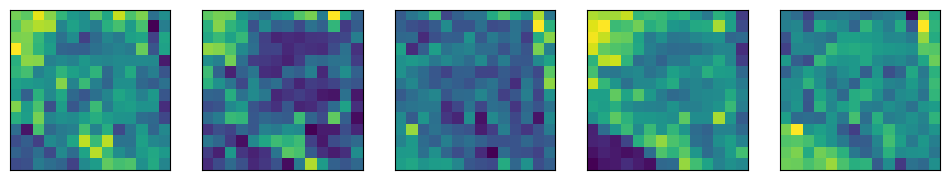

In [29]:
import random
random_indexes = random.sample(range(0, 768), k = 5)
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

for i, idx in enumerate(random_indexes):
  feature_map = image_out_of_conv2d[:, idx, :, :]
  axs[i].imshow(feature_map.squeeze().detach().numpy())
  axs[i].set(xticks = [], yticks = [], xticklabels = [], yticklabels=[])


In [30]:
flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3)
flattened_embedding = flatten_layer(image_out_of_conv2d)
print(f"Shape out of Flattened Layer: {flattened_embedding.shape}")
desired_embedding = flattened_embedding.permute(0, 2, 1)
print(f"Our desired embedding shape: {desired_embedding.shape}")

Shape out of Flattened Layer: torch.Size([1, 768, 196])
Our desired embedding shape: torch.Size([1, 196, 768])


In [35]:
class EmbeddingLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv2d = nn.Conv2d(in_channels = image_channels,
                            out_channels = patch_size * patch_size * image_channels,
                            stride = patch_size,
                            kernel_size = patch_size,
                            padding = 0)
    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)


  def forward(self, x):
    x = self.conv2d(x)
    x = self.flatten(x)
    x = x.permute(0, 2, 1)
    return x

embedding_model = EmbeddingLayer()
desired_embedding = embedding_model(image.unsqueeze(0))
print(f"We fucking did it.\nDesired Embedding Shape: {desired_embedding.shape}")

We fucking did it.
Desired Embedding Shape: torch.Size([1, 196, 768])


(-0.5, 195.5, 0.5, -0.5)

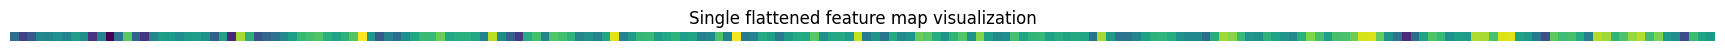

In [38]:
single_flattened_feature_map = desired_embedding[:, :, 0]
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title("Single flattened feature map visualization")
plt.axis("off")

In [50]:
class PatchEmbeddingLayer(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               embedding_dim: int = 768,
               patch_size: int = 16):
    super().__init__()
    self.patch_size = patch_size
    self.embedding_dim = embedding_dim
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)
    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

  def forward(self, x):
    input_shape = x.shape[-1]
    assert input_shape % self.patch_size == 0, "Input size must be divisible by patch_size"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)


In [61]:
patchify = PatchEmbeddingLayer(in_channels = 3, embedding_dim = 768, patch_size = 16)

print(f"Image input shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Shape of image out of Patch Embedding Layer: {patch_embedded_image.shape}")


Image input shape: torch.Size([1, 3, 224, 224])
Shape of image out of Patch Embedding Layer: torch.Size([1, 196, 768])


In [62]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim), requires_grad = True)
patch_embedded_image_with_class_embedding = torch.cat([class_token, patch_embedded_image], dim = 1)
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embedded image with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}")


tensor([[[ 0.5824, -1.0129,  1.9619,  ..., -1.1079,  0.7794, -1.6710],
         [ 0.4696, -0.6802, -0.1688,  ...,  0.2525, -0.2666, -0.8725],
         [ 0.4219, -0.7092, -0.2429,  ...,  0.2407, -0.2398, -0.8093],
         ...,
         [ 0.4708, -0.6423, -0.1023,  ...,  0.1758, -0.3374, -0.4676],
         [ 0.2618, -0.5834, -0.0972,  ...,  0.1116, -0.2713, -0.4400],
         [ 0.2237, -0.5167, -0.0966,  ...,  0.1154, -0.2512, -0.4418]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedded image with class token prepended shape: torch.Size([1, 197, 768])


In [66]:
number_of_patches = int((image_height * image_width)/patch_size ** 2)
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.randn(batch_size, number_of_patches + 1, embedding_dim), requires_grad = True)
position_and_class_embedded_images = patch_embedded_image_with_class_embedding + position_embedding
position_and_class_embedded_images, position_and_class_embedded_images.shape

(tensor([[[ 0.3911, -2.2918,  1.5728,  ...,  0.3843,  0.0774, -1.7726],
          [-1.3522, -0.0350,  0.6498,  ...,  0.1997, -0.0719, -0.8655],
          [ 1.0034,  1.0255, -0.1449,  ...,  1.5234, -1.0296,  0.3479],
          ...,
          [-0.1072,  1.5866, -0.4582,  ...,  1.4040,  1.5860,  0.2035],
          [-0.1887, -0.9243, -0.5547,  ...,  1.0943, -0.8368,  0.1705],
          [ 0.6694, -0.5726,  0.0705,  ..., -2.2724, -0.6701, -0.6486]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               embedding_dim: int = 768,
               patch_size: int = 16,
               img_height: int = 224,
               img_width: int = 224):
    super().__init__()
    self.patcher = nn.Conv2D(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)
    self.num_patches = int((img_height * img_width)/patch_size ** 2)

  def forward(self, x):
    x = self.patcher(x)
    x = self.flatten(x)
    x = x.permute(0, 2, 1)
    batch_size = x.shape[0]
    embedding_dim = x.shape[-1]
    class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim), requires_grad = True)
    x = torch.cat([class_token, x], dim = 1)
    position_embedding = nn.Parameter(torch.randn(batch_size, self.num_patches, embedding_dim), requires_grad = True)
    x = x + position_embedding
    return x